In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
file = '../penning_trap_comsol/output.csv'

In [45]:
class Grid: 
    def __init__(self, x=[], y=[], z=[]): 
        self.x, self.y, self.z = x, y, z
        self.has_grid_center = False
        
    def get_xyz_array(self): 
        return self.x, self.y, self.z 

    def get_xyz_set(self):
        return np.array([self.x, self.y, self.z]).transpose()

    def get_subgrid_xyzi(self, xmin, xmax, ymin, ymax, zmin, zmax): 
        ix = np.where((self.x > xmin) & (self.x < xmax) & 
                      (self.y > ymin) & (self.y < ymax) & 
                      (self.z > zmin) & (self.z < zmax))
        return self.x[ix], self.y[ix], self.z[ix], ix

    def get_grid_center(self): 
        if not self.has_grid_center: 
            self.initialize_grid_center()
        return self.x0, self.y0, self.z0 
        
    def initialize_grid_center(self): 
        self.x0 = self.x[np.argmin(abs(self.x - abs(1/2*(max(self.x)+min(self.x)))))]
        self.y0 = self.y[np.argmin(abs(self.y - abs(1/2*(max(self.y)+min(self.y)))))] 
        self.z0 = self.z[np.argmin(abs(self.z - abs(1/2*(max(self.z)+min(self.z)))))] 
        self.initialized_grid_center = True

    def scale_xyz(self, r0): 
        self.x = self.x / r0 
        self.y = self.y / r0 
        self.z = self.z / r0 
        self.initialize_grid_center()
        
        
class COMSOLGrid(Grid): 
    def __init__(self, df, unit=1e-6,
                 header_x='% x', header_y='y', header_z='z', 
                 **kwargs): 
        super().__init__()
        self.x = np.array(df[header_x]) * unit
        self.y = np.array(df[header_y]) * unit
        self.z = np.array(df[header_z]) * unit
        self.x_step, self.y_step, self.z_step = self.initialize_resolution()

    def initialize_resolution(self):  
        dx, dy, dz = 0, 0, 0
        for i in range(len(self.x)-1):
            dx0 = self.x[i+1] - self.x[i] 
            dy0 = self.y[i+1] - self.y[i] 
            dz0 = self.z[i+1] - self.z[i]
            dx = dx0 if dx0 > 0 else dx 
            dy = dy0 if dy0 > 0 else dy 
            dz = dz0 if dz0 > 0 else dz 
            if dx > 0 and dy > 0 and dz > 0: 
                break
        return dx, dy, dz

    def get_resolution(self): 
        return self.x_step, self.y_step, self.z_step

    def gen_subgrid(self, xmin, xmax, ymin, ymax, zmin, zmax): 
        x, y, z, _ = self.get_subgrid_xyzi(xmin, xmax, ymin, ymax, zmin, zmax) 
        return Grid(x, y, z)

    def gen_subcube(self, L_cube): 
        x0, y0, z0 = self.get_grid_center() 
        x, y, z, _ = self.get_subgrid_xyzi(x0-L_cube/2, x0+L_cube/2, 
                                           y0-L_cube/2, y0+L_cube/2, 
                                           z0-L_cube/2, z0+L_cube/2)
        return CubeGrid(x, y, z, L_cube)
            

class CubeGrid(Grid): 
    def __init__(self, x, y, z, L_cube): 
        super().__init__(x, y, z) 
        self.L_cube = L_cube
    
class CustomizedGrid(Grid): 
    def __init__(self, xmin, xmax, xstep, ymin, ymax, ystep, zmin, zmax, zstep): 
        super().__init__() 
        self.x = np.arange(xmin, xmax, xstep) 
        self.y = np.arange(ymin, ymax, ystep) 
        self.z = np.arange(zmin, zmax, zstep) 

class CustomCubeGrid(CustomizedGrid):
    def __init__(self, rmax, rmin, rstep): 
        super().__init__(rmin, rmax, rstep, rmin, rmax, rstep, rmin, rmax, rstep)
        self.L = rmax - rmin 

In [46]:
class COMSOLElectrode: 
    def __init__(self, name, file, grid_resolution=1, unit=1e-6, 
                 header_x='% x', header_y='y', header_z='z', **kwargs): 
        self.V, self.Ex, self.Ey, self.Ez, self.sim_grid = self.load_from_file(name, file, 
                                                                               unit=unit, 
                                                                               header_x='% x', 
                                                                               header_y='y', 
                                                                               header_z='z', **kwargs) 

    def load_from_file(self, electrode, file, excitation_prefix='V', sim_prefix='esbe.', skiprows=8, 
                       unit=1e-6, header_x='% x', header_y='y', header_z='z', **kwargs): 
        df = pd.read_csv(file, skiprows=skiprows) 
        all_headers = [i for i in df.keys() if f'{excitation_prefix}{electrode}=1' in i] 
        V_headers = [i for i in all_headers if f'{sim_prefix}V' in i] 
        Ex_headers = [i for i in all_headers if f'{sim_prefix}Ex' in i]
        Ey_headers = [i for i in all_headers if f'{sim_prefix}Ey' in i] 
        Ez_headers = [i for i in all_headers if f'{sim_prefix}Ez' in i] 
        assert len(V_headers)==1, "Check output results or output headers, found 0 or 1+ potential data"
        V = np.array(df[V_headers[0]]) 
        Ex = np.array([]) if len(Ex_headers) != 1 else np.array(df[Ex_headers[0]]) 
        Ey = np.array([]) if len(Ey_headers) != 1 else np.array(df[Ey_headers[0]]) 
        Ez = np.array([]) if len(Ez_headers) != 1 else np.array(df[Ez_headers[0]]) 
        grid = COMSOLGrid(df, unit, header_x, header_y, header_z) 
        return V, Ex, Ey, Ez, grid
        
    def get_V_in_cube(self, V0=1, L_cube=None): 
        if L_cube is None: 
            return V0 * self.V 
        x0, y0, z0 = self.sim_grid.get_grid_center() 
        V_idx = self.sim_grid.get_subgrid_xyzi(x0-L_cube/2, x0+L_cube/2, 
                                               y0-L_cube/2, y0+L_cube/2, 
                                               z0-L_cube/2, z0+L_cube/2)[-1] 
        return V0 * self.V[V_idx]

    def get_subcube_Vxyz(self, V0=1, L_cube=None): 
        if L_cube is None: 
            return V0 * self.V 
        x0, y0, z0 = self.sim_grid.get_grid_center() 
        X, Y, Z, V_idx = self.sim_grid.get_subgrid_xyzi(x0-L_cube/2, x0+L_cube/2, 
                                               y0-L_cube/2, y0+L_cube/2, 
                                               z0-L_cube/2, z0+L_cube/2)
        return V0 * self.V[V_idx], X, Y, Z

    def set_sim_grid(self, grid): 
        self.sim_grid = grid

In [5]:
from juliacall import Main as jl
#jl.seval("using Pkg")
#jl.Pkg.add("SphericalHarmonicExpansions")
jl.seval("using SphericalHarmonicExpansions") 

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [80]:
def plot_3D_potential(coord, Phi, size=1, n=100, scale=1,
                   cmap='viridis', title=r'$\Phi(x,y,z)$',
                   ax=None):
    x, y, z = coord
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot
    sc = ax.scatter(x[::n]*scale, y[::n]*scale, z[::n]*scale, 
                    s=size, c=Phi[::n], 
                    marker='.', cmap=cmap)
    
    # Add color bar
    cb = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
    cb.set_label('Potential (V)')
    
    # Labels and display
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    ax.set_zlabel('z (um)')
    
    plt.show()

def plot_potential(coord, Phi, size=1, n=100, scale=1,
                   cmap='viridis', title=r'$\Phi(x,y,z)$',
                   ax=None):
    x, y, z = coord
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
    im = ax.scatter(x[::n]*scale, y[::n]*scale, z[::n]*scale, 
                    s=size, c=Phi[::n], 
                    marker='.', cmap=cmap)
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    ax.set_zlabel('z (um)')
    ax.set_title(title)
    if ax is None:
        fig.colorbar(im, ax=ax, shrink=0.8)
        plt.tight_layout()
        plt.show()
    else:
        return im
        
def plot_all_potentials(plot_coord_fit, V, Phi, m, plot_scale=1):
    """
    Plot the original, fitted, and residual potential.
    """
    fig1 = plt.figure(figsize=plt.figaspect(1/3))
    ax1 = fig1.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig1.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig1.add_subplot(1, 3, 3, projection='3d')
    
    im1 = plot_potential(plot_coord_fit, V.flatten(), size=10, n=m, scale=plot_scale, 
                   title=r'Original $\Phi(x,y,z)$', ax=ax1)
    im2 = plot_potential(plot_coord_fit, Phi.flatten(), size=10, n=m, scale=plot_scale, 
                   title=r'Fit $\Phi(x,y,z)$', ax=ax2)
    im3 = plot_potential(plot_coord_fit, abs(Phi.flatten()-V.flatten()), size=10, n=m, scale=plot_scale, 
                   title=r'Residual $\Delta\Phi(x,y,z)$', cmap='Reds', ax=ax3)
    fig1.colorbar(im1, ax=ax1, shrink=0.8)
    fig1.colorbar(im2, ax=ax2, shrink=0.8)
    fig1.colorbar(im3, ax=ax3, shrink=0.8)
    plt.tight_layout()
    plt.show()

def add_value_labels(ax, spacing=0.1, threshold=0.01):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        if abs(y_value) < threshold:
            continue
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
        
def plot_Mj(Mj, mutipole_names=['C', 'Ey', 'Ez', 'Ex', 'U3', 'U4', 'U2', 'U5', 'U1'], 
            Mj_threshold=0.01,
            title='', save_fig=False):
    
    fig, ax = plt.subplots(figsize=(0.3*len(Mj), 4))
    ax.bar(list(range(1,len(Mj)+1)), Mj.flatten())
    add_value_labels(ax, threshold=Mj_threshold)
    #ax.axvline(np.argmax(abs(Mj))+1, label='j ='+str(np.argmax(abs(Mj))+1), 
    #            linestyle='--', color='r', alpha=0.7)
    tick_name = list(mutipole_names)
    tick_name += list(range(len(tick_name)+1, len(Mj)+1))
    df = pd.DataFrame({'Mj': [f'{float(i):.3e}' for i in Mj]}, index=tick_name)
    try:
        display(df)
    except:
        print(df)
    ax.set_xticks(range(1,len(Mj)+1), tick_name, rotation = -90)
    ax.set_xlabel(r'$j$')
    ax.set_ylabel(r'$M_j$')
    #ax.legend()
    ax.grid()
    ax.set_title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{title}.pdf')
    plt.show() 
    
def eval_spherical_harmonics(C, x, y, z):
    jl.seval(f'C = {list(C)}')
    jl.seval("c = SphericalHarmonicCoefficients(C)")
    jl.seval("@polyvar x y z")
    jl.seval("f = sphericalHarmonicsExpansion(c, x, y, z)")
    fastf = jl.seval("(x,y,z) -> fastfunc(f)([x,y,z])")
    result = jl.broadcast(fastf, x, y, z) 
    return np.array(result)

def eval_spherical_harmonics_by_term(x, y, z, order=2): 
    N = (order+1)**2 
    V_list = []
    for i in range(N): 
        C = np.zeros(N) 
        C[i] = 1
        V_list.append(eval_spherical_harmonics(C, x, y, z)) 
    return np.array(V_list).T
    
def get_Cj_list(C=0, Ey=0, Ez=0, Ex=0, U3=0, U4=0, U2=-1, U5=0, U1=0, **kwargs):
    multipole_coeffs = [C, Ey, Ez, Ex, U3, U4, U2, U5, U1]
    L = 2
    for mj in kwargs: 
        term = int(mj[1:])  
        while (L+1)**2 < term: 
            L += 1 
    
    N_terms = (L+1)**2 
    C = np.zeros(N_terms)
    for i in range(N_terms): 
        if i < 9: 
            C[i] = multipole_coeffs[i] 
        elif f'm{i}' in kwargs: 
            C[i] = kwargs[f'm{i}'] 
    return C

def get_Cj_fit(V, x, y, z, order=2): 
    V_spherical_harmonics_matrix = eval_spherical_harmonics_by_term(x, y, z, order=order) 
    return np.linalg.lstsq(V_spherical_harmonics_matrix, V, rcond=None)

In [82]:
class COMSOLTrap: 
    def __init__(self, result_file, electrodes, r0=1e-6, L_ROI=50, skiprows=8, **kwargs): 
        self.sim_grid = COMSOLGrid(pd.read_csv(result_file, skiprows=skiprows), **kwargs)  # Grid used in COMSOL simulation
        self.sim_grid.scale_xyz(r0) 
        self.ROI_grid = self.sim_grid.gen_subcube(L_cube=L_ROI) 
        self.electrodes = {} 
        for ei in electrodes: 
            self.electrodes[ei] = COMSOLElectrode(ei, result_file, **kwargs) 
            self.electrodes[ei].set_sim_grid(self.sim_grid)
        self.V_matrix_ROI = self.get_V_matrix_ROI() 
        self.constructed_V_total = False
        
    def get_V_matrix_ROI(self): 
        V = [] 
        for ei in self.electrodes: 
            V.append(self.electrodes[ei].get_V_in_cube(L_cube=self.ROI_grid.L_cube)) 
        return np.array(V).T

    def get_electrode_voltages(self, C=0, Ey=0, Ez=0, Ex=0, 
                               U3=0, U4=0, U2=-1, U5=0, U1=0, **kwargs): 
        Cj_ideal = get_Cj_list(C=C, Ey=Ey, Ez=Ez, Ex=Ex, 
                               U3=U3, U4=U4, U2=U2, U5=U5, U1=U1, **kwargs)
        x, y, z = self.ROI_grid.get_xyz_array() 
        V_ideal = eval_spherical_harmonics(Cj_ideal, x, y, z) 
        V_DC = np.linalg.lstsq(self.V_matrix_ROI, V_ideal, rcond=None)[0] 
        return V_DC 

    def construct_V_total(self, C=0, Ey=0, Ez=0, Ex=0, 
                          U3=0, U4=0, U2=-1, U5=0, U1=0, **kwargs): 
        V_DC = self.get_electrode_voltages(C=C, Ey=Ey, Ez=Ez, Ex=Ex, 
                                           U3=U3, U4=U4, U2=U2, U5=U5, U1=U1, **kwargs)
        V_total = np.dot(self.V_matrix_ROI, V_DC) 
        self.V_DC = V_total 
        self.constructed_V_total = True

    def expand_spherical_harmonics(self, order=2): 
        assert self.constructed_V_total, "Construct the desired total potential" + \
                                         "using self.construct_V_total(...) first"
        x, y, z = self.ROI_grid.get_xyz_array() 
        self.Cj_fit = get_Cj_fit(self.V_DC, x, y, z, order=order)[0]

    def reconstruct_V_fit(self): 
        assert hasattr(self, "Cj_fit"), "Construct spherical harmonics expansion" + \
                                        "using self.expand_spherical_harmonics(...) first"
        x, y, z = self.ROI_grid.get_xyz_array() 
        self.V_fit = eval_spherical_harmonics(self.Cj_fit, x, y, z)
        plot_all_potentials((x, y, z), self.V_DC, self.V_fit, m=1, plot_scale=1)

In [83]:
electrodes = ['e1', 'c1', 'r', 'c2', 'e2'] 
trap = COMSOLTrap(file, electrodes, r0=1e-3, roi=50e-3)

In [93]:
trap.construct_V_total() 
trap.expand_spherical_harmonics(order=8)

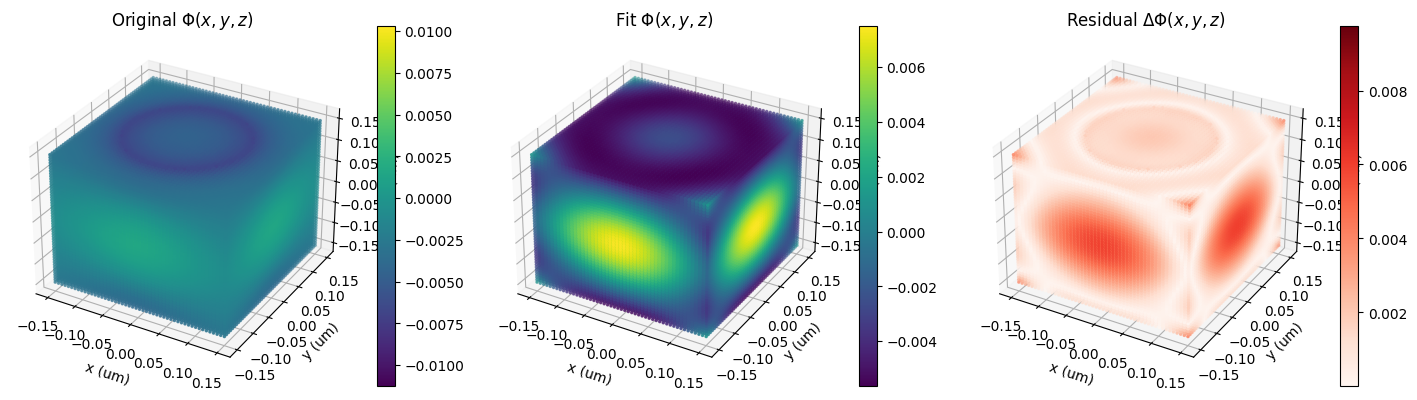

In [94]:
trap.reconstruct_V_fit()

,Mj
C,2.190e-03
Ey,-5.458e-11
Ez,-1.185e-06
Ex,1.950e-10
U3,0.000e+00
...,...
77,4.780e+02
78,3.170e-06
79,1.439e-10
80,1.751e-06


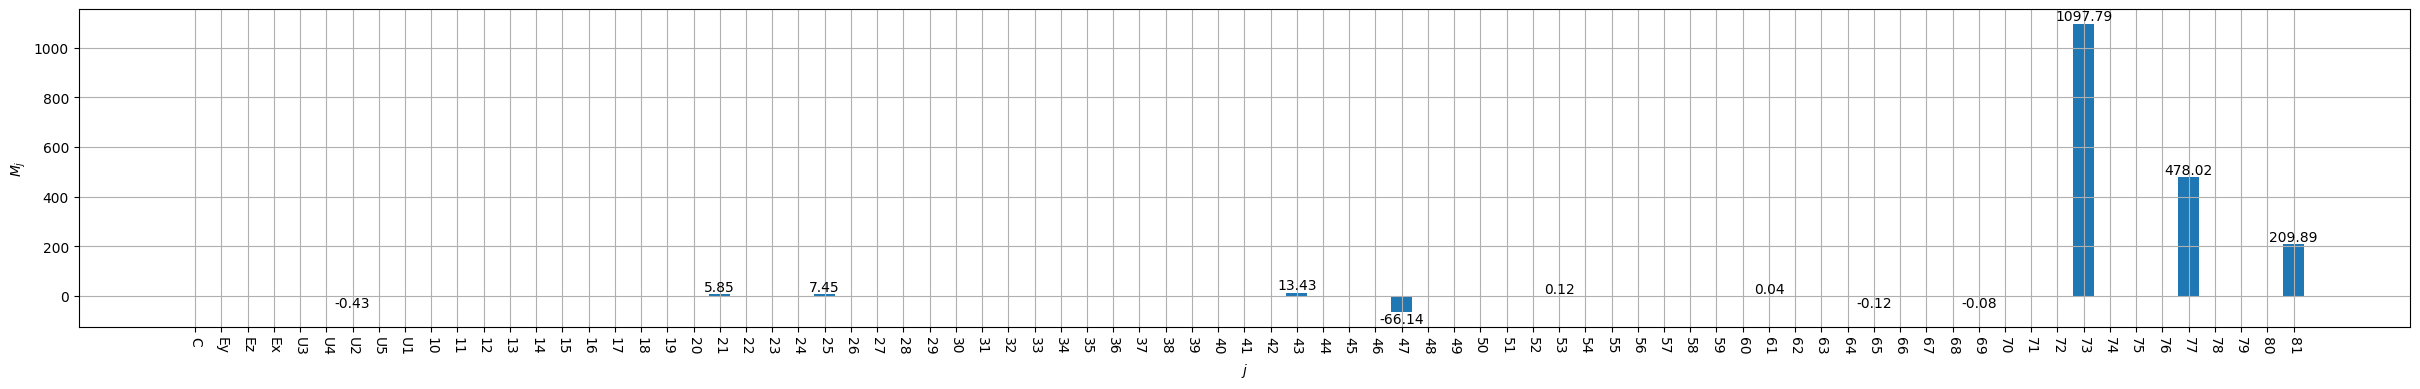

In [95]:
plot_Mj(trap.Cj_fit)